In [67]:
# Jupyter setup to expand cell display to 100% width on your screen (optional)
# Import relevant modules and setup for calling glmnet
%reset -f
%matplotlib inline

from sqlalchemy import create_engine
import sys
import pandas as pd
import numpy as np
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

import statsmodels.api as sm
import statsmodels.genmod as genmod
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [68]:
# Machine learning 
from sklearn.ensemble import RandomForestRegressor

In [139]:
localhost = {'user': 'postgres', 'password': 'postgres', 'host': 'localhost', 'port': 5432, 'db': 'fiadb'}
params = 'postgresql://{0}:{1}@{2}:{3}/{4}'
engine = create_engine(params.format(localhost['user'], localhost['password'], localhost['host'], localhost['port'], localhost['db']))
pergrid_base = """select distinct * from predictor.pergrid_base"""
pergrid_base_df = pd.read_sql(pergrid_base, engine)

In [140]:
y_true = pergrid_base_df['tsr']
grid_id = pergrid_base_df['grid_id']

In [141]:
pred_var= ['aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
       'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt','shg', 'mtwq', 'wa']

PRED_VAR= ['AET', 'AI', 'ART', 'EWD', 'FA', 'MAP', 'MAT', 'MPDQ',
       'MTCQ', 'PET', 'PSN', 'RA', 'RMAP', 'RMAT', 'TSN', 'MFDF', 'ALT','SHG', 'MTWQ', 'WA']

In [142]:
pergrid_base_pred_df = pergrid_base_df[pred_var]

In [143]:
pergrid_base_pred_df.head()

,aet,ai,art,ewd,fa,map,mat,mpdq,mtcq,pet,psn,ra,rmap,rmat,tsn,mfdf,alt,shg,mtwq,wa
0,6000.0,0.3675,21.191667,-2.523666e+06,7.7058,681.0,20.036236,87.0,16.299375,1826.768199,50.411522,16.0,2.833333,0.604166,444.860212,2.27,11.597701,None,28.792500,4.1166
1,65535.0,0.3829,20.233612,-2.537902e+06,14.1498,699.0,20.298634,92.0,16.340292,1811.927757,49.797996,14.0,2.000000,0.620833,444.259982,2.10,5.982890,5,28.717458,11.8152
2,65535.0,NaN,0.164286,-5.247088e+02,0.0711,1148.5,0.309987,131.5,21.304167,1918.111111,0.713689,1.0,1.833333,0.241667,3.698817,NaN,0.011696,None,28.626191,302.9049
3,5135.0,0.2898,23.950167,-2.941595e+06,3.0042,565.0,20.193576,76.0,15.517042,1972.128352,43.001180,108.0,2.333333,0.391667,492.281141,2.12,61.886973,None,29.458834,1.2528
4,5645.0,0.3017,23.526261,-2.959517e+06,10.0350,580.0,20.710174,80.0,15.754000,1928.968811,44.328019,34.0,3.416667,0.620833,489.587254,2.12,32.270955,5,29.300416,4.2480


In [144]:
imputer = KNNImputer(n_neighbors=5)
pergrid_base_pred_filled = imputer.fit_transform(pergrid_base_pred_df)
pergrid_base_df = pd.DataFrame(pergrid_base_pred_filled)

# standarize predictors
ss = StandardScaler(with_mean=False, with_std=False)
X_std = ss.fit_transform(pergrid_base_df)

Xstd=pd.DataFrame(data=X_std[0:,0:],
                index=pergrid_base_pred_df.index,
                columns=pred_var)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(Xstd, y_true, test_size=0.2, random_state=0)

In [146]:
print("Training Random Forest Regressor...")
rf = RandomForestRegressor(n_estimators = 10, random_state = 42, bootstrap=True)
rf.fit(X_train, y_train)

Training Random Forest Regressor...


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [147]:
y_pred = rf.predict(X_test)

In [148]:
test_score_cv=rf.score(X_test,y_test)
print("Test score: ", test_score_cv)

Test score:  0.8941809084313583


In [149]:
# Grid and Random Search best hyperparameters
import time
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

Reducing computational expense using RandomizedSearchCV
- Searching many different parameters at once may be computationally infeasible
- RandomizedSearchCV searches a subset of the parameters, and you control the computational "budget"

In [150]:
# Specify parameters and distributions to sample from
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]
# max number of features considered for splitting a node
max_features = ['auto', 'sqrt']
# max number of levels in each decision tree
max_depth = [int(x) for x in np.linspace(30, 80, num = 10)]
max_depth.append(None)
# min number of data points placed in a node before the node is split
min_samples_split = [5, 10]
# min number of data points allowed in a leaf node
min_samples_leaf = [5, 10]
# Method of selecting samples for training each tree
bootstrap = [True]
criterion = ["mse"]

In [151]:
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

# Run Randomized Search
n_iter_search = 100 # Number of parameter settings that are sampled 
rfr = RandomForestRegressor()
random_search = RandomizedSearchCV(estimator = rfr, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search,
                                   n_jobs = -1, # using all processors
                                   cv = 10)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 1984.65 seconds for 100 candidates parameter settings.


In [152]:
random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 68,
 'criterion': 'mse',
 'bootstrap': True}

In [153]:
random_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=68, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Evaluation Metrics

In [154]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [155]:
Y_train_pred = random_search.predict(X_train)
print('train MAE', mean_absolute_error(Y_train_pred, y_train))
print('train r2', r2_score(y_train, Y_train_pred))

train MAE 1.9317056635005558
train r2 0.9547566033094702


In [156]:
from sklearn.metrics import mean_squared_error
import math

Y_train_pred = random_search.predict(X_train)
rmse = math.sqrt(mean_squared_error(Y_train_pred, y_train))

print('train RMSE', rmse)
print('train r2', r2_score(y_train, Y_train_pred))

train RMSE 2.7619895979791154
train r2 0.9547566033094702


In [157]:
Y_test_pred = random_search.predict(X_test)
print('test MAE', mean_absolute_error(Y_test_pred, y_test))
print('test r2', r2_score(y_test, Y_test_pred))

test MAE 2.9042478817557096
test r2 0.9031499271677292


In [161]:
Y_test_pred = random_search.predict(X_test)
rmse = math.sqrt(mean_squared_error(Y_test_pred, y_test))

print('test RMSE', rmse)
print('test r2', r2_score(y_test, Y_test_pred))

test RMSE 4.073682370193777
test r2 0.9031499271677292


In [162]:
rf_y_test = pd.DataFrame(
    {'tsr': y_test,
     'tsr_predicted': Y_test_pred})
rf_y_test.to_sql(name='rf_y_test', con=engine, schema='predictor', if_exists='replace', index=False)

### Feature Importance

In [163]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), random_search.best_estimator_.feature_importances_), pred_var), 
             reverse=True))

Features sorted by their score:
[(0.1865, 'ai'), (0.1489, 'mpdq'), (0.1242, 'fa'), (0.1051, 'map'), (0.0881, 'aet'), (0.0587, 'alt'), (0.0378, 'pet'), (0.0361, 'psn'), (0.0282, 'art'), (0.0248, 'tsn'), (0.0218, 'mat'), (0.0217, 'mfdf'), (0.0215, 'mtcq'), (0.0206, 'ewd'), (0.0193, 'ra'), (0.018, 'wa'), (0.0177, 'mtwq'), (0.011, 'rmat'), (0.0081, 'rmap'), (0.0017, 'shg')]


In [164]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

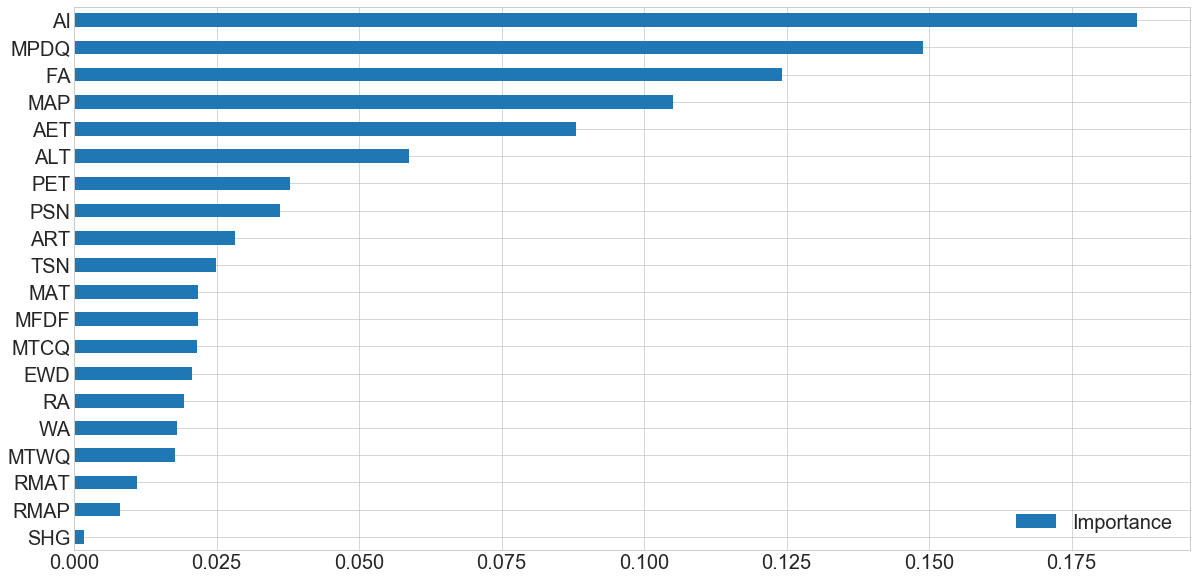

In [165]:
importance = random_search.best_estimator_.feature_importances_
importance = pd.DataFrame(importance, index=PRED_VAR, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

### Make TSR predictions using the full dataset

In [166]:
y_pred_all = random_search.predict(Xstd)

In [167]:
pergrid_all_predicted = pd.DataFrame(
    {'grid_id': grid_id,
     'tsr': y_true,
     'tsr_predicted': y_pred_all.tolist()})

In [168]:
pergrid_all_predicted.head(10)

,grid_id,tsr,tsr_predicted
0,110,4.0,2.944604
1,111,2.0,2.626410
2,195,5.0,3.855186
3,337,1.0,1.820770
4,338,1.0,2.102745
5,339,2.0,2.407939
6,340,2.0,2.699387
7,342,2.0,2.648041
8,343,1.0,3.143369
9,567,3.0,2.289756


In [169]:
pergrid_all_predicted.to_sql(name='random_forest', con=engine, schema='predictor', if_exists='replace', index=False)

/Users/lianfeng/miniconda3/lib/python3.7/site-packages/sqlalchemy/dialects/postgresql/base.py:3028: SAWarning: Did not recognize type 'geometry' of column 'wkb_geometry'
  "Did not recognize type '%s' of column '%s'" % (attype, name)


In [170]:
update_geom = """
alter table predictor.random_forest add column if not exists wkb_geometry geometry(Polygon,4269);
update predictor.random_forest A SET wkb_geometry = B.wkb_geometry
FROM predictor.pergrid_base B
WHERE A.grid_id = B.grid_id
"""

In [171]:
connection = engine.connect()
connection.execute(update_geom)

In [172]:
update_residual = """
alter table predictor.random_forest add column residual double precision;
update predictor.random_forest set residual = (tsr_predicted-tsr);
"""

In [173]:
connection = engine.connect()
connection.execute(update_residual)